# Maximum Likelihood Estimation

In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from myst_nb import glue

import os
if os.name == 'nt':
    plt.style.use('book.mplstyle')  # Windows

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


Let's consider the simplest possible scenario, where some force $f_y$ is modelled as function of velocity $v$ and some hydrodynamic coefficient $\beta$:

$$ f_y = \beta \cdot v  $$ (eq_model)

One physical experiment is carried out where the force $f_y$ is measured at a certain speed $v$. (We also measure that there is no force at rest ($v=0$) to confirm the lack of interception term in the model {eq}`eq_model`)

In [2]:
# generate data
np.random.seed(42)
N = 10

beta = 3
scale = 1.0

data = pd.DataFrame()
v = data['v'] = np.linspace(0,5,N)
ϵ = data['ϵ'] = np.random.normal(loc = 0.0, scale = scale, size = N)
f_y = data['f_y'] = beta*v
f_y_measure = data['f_y_measure'] = f_y + ϵ




In [3]:
n = 5
f_y_sample = f_y[n]
v_sample = v[n]
beta_hat = f_y_sample/v_sample
glue("f_y_sample", f_y_sample, display=False)
glue("v_sample", v_sample, display=False)
glue("beta_hat", beta_hat, display=False)

In [4]:
data['beta'] = data['f_y'] / data['v']
glue("tab_experiments", data[['v','f_y_measure']])

,v,f_y_measure
0,0.000000,0.496714
1,0.555556,1.528402
2,1.111111,3.981022
3,1.666667,6.523030
4,2.222222,6.432513
5,2.777778,8.099196
6,3.333333,11.579213
7,3.888889,12.434101
8,4.444444,12.863859
9,5.000000,15.542560


{glue:}`f_y_sample` [N] force ($f_y$) was measured during the conducted experiment at a speed ($v$) of {glue:}`v_sample` [m/s].  
As the model ({eq}`eq_model`) contains only one unknown parameter: $\beta$ this one only experiment is enought to determine $\beta$:
$$\beta = \frac{f_y}{v} $$ (eq_beta_deterministic)
So that beta can be estimated as {glue:}`beta_hat`.

If the measurement was perfect and the used model describes the physics perfectly this estimation of $\beta$ is the correct one. In order to double check this several experiment was conducted, as seen in the table below:

{glue:`tab_experiments`}

It can be seen that {eq}`eq_beta_deterministic` gives different estimates of $\beta$ from the different experiments. So there must be some measurement errors or model errors (or booth) in the data from these experiments.

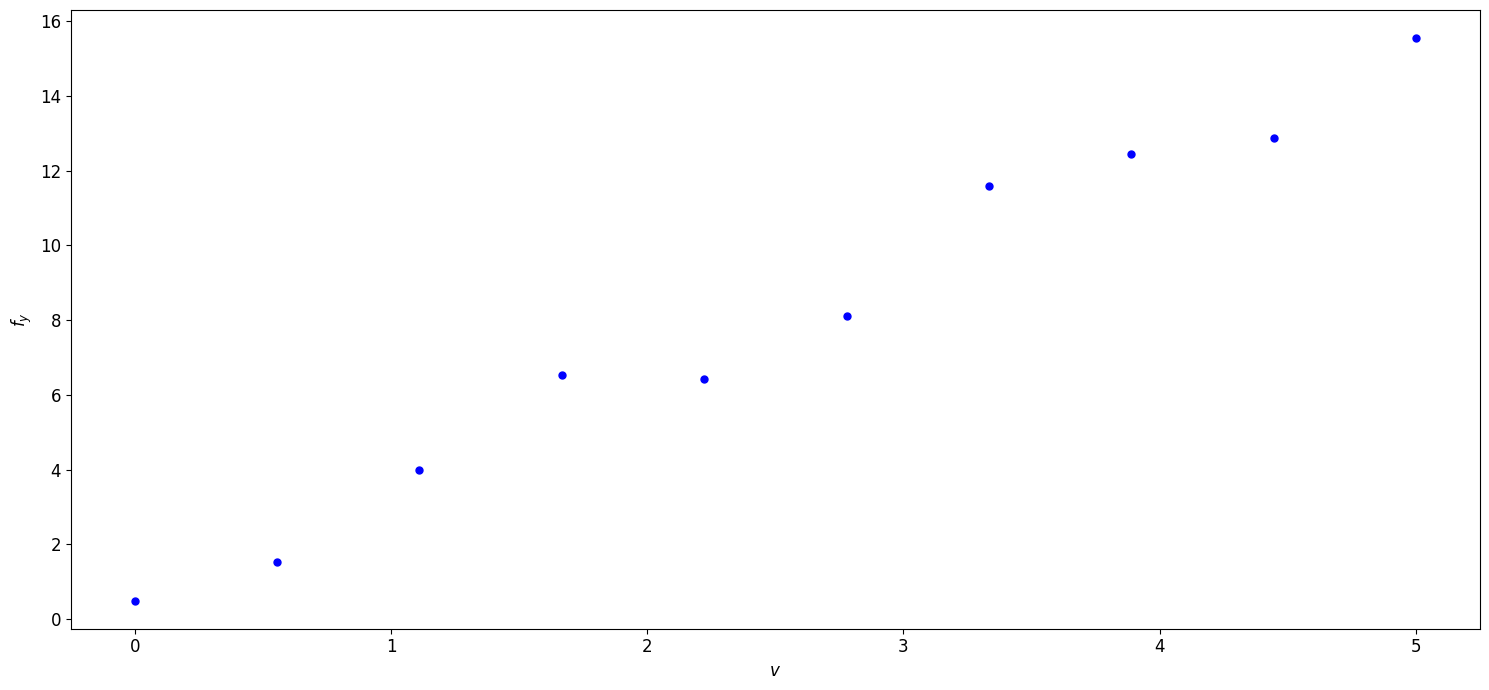

In [5]:
fig,ax=plt.subplots()
data.plot(x='v', y='f_y_measure', style='bo', ax=ax);
ax.set_ylabel(r'$f_y$')
ax.set_xlabel(r'$v$');
ax.get_legend().set_visible(False)

If it is asumed that the deviations comes from measurement errors, it is common to assume that this error $\epsilon$ follows the normal distribution with zero mean and some standard deviation $\sigma$:
$$\epsilon = N(0,\sigma)$$
The figure below shows the probability density plot (PDF) of a normal distribution for measurement error. Having no error $epsilon=0$ has the highest probability, and values very far away from zero, like +/- 2 N have very low probability.

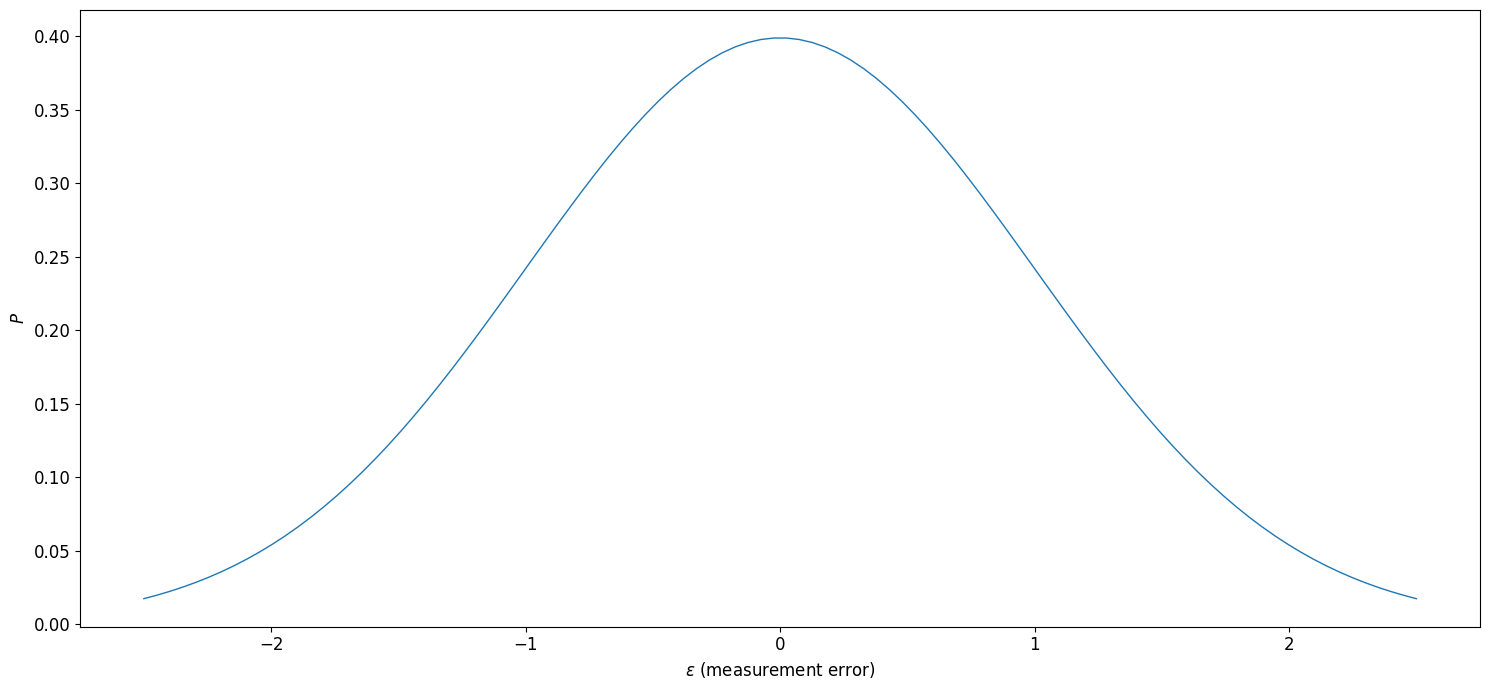

In [6]:
ϵ = stats.norm(loc=0, scale=scale)

epsilons = np.linspace(-2.5*scale,2.5*scale,100)
p = ϵ.pdf(epsilons)

fig,ax=plt.subplots()
ax.plot(epsilons,p);
ax.set_xlabel(r'$\epsilon$ (measurement error)');
ax.set_ylabel(r'$P$');


The measurement error can now be added to the estimation of $f_y$ by modifying the model equation ({eq}`eq_model`):

$$ f_y = \beta \cdot v + \epsilon $$ (eq_model_probabalisic)

The regression problem can now be solved if we can find the normal distribution that created the measurement noise as seen in the figure below.

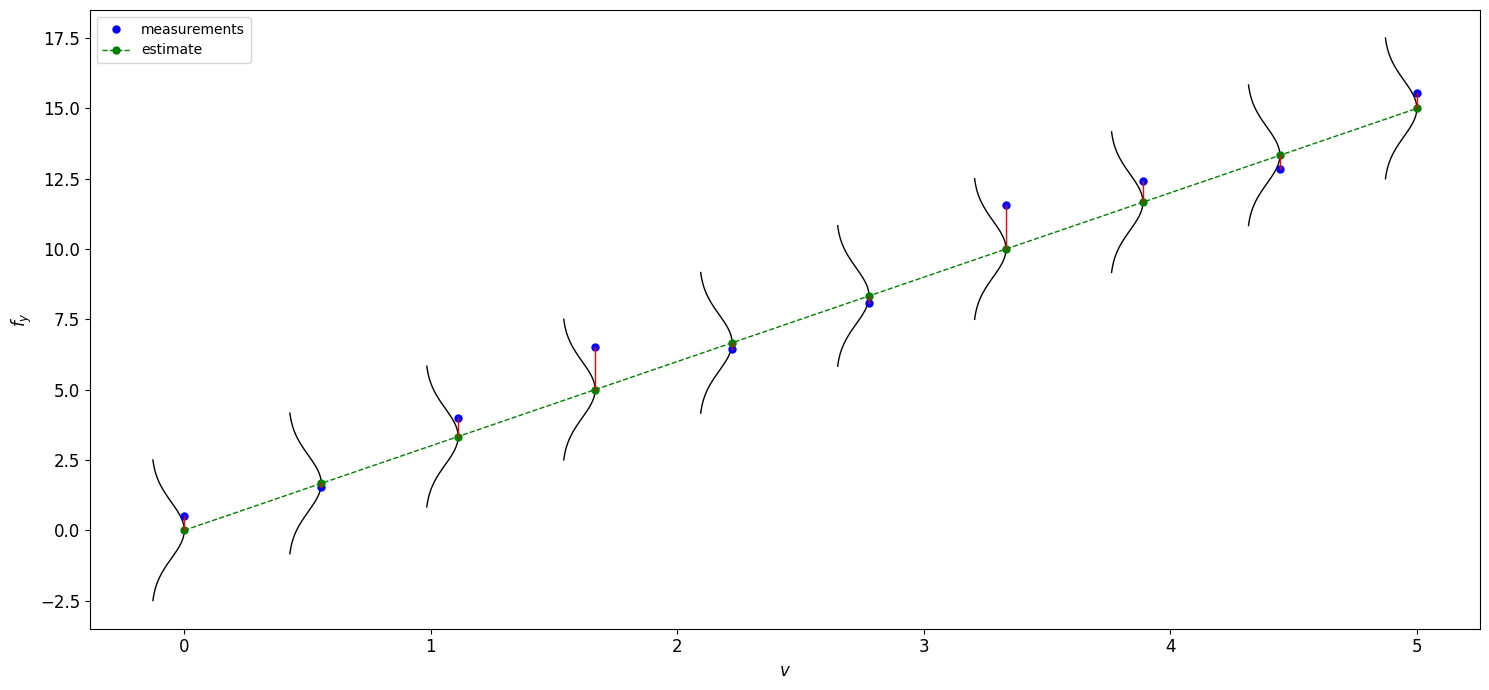

In [7]:
fig,ax=plt.subplots()
data.plot(x='v', y='f_y_measure', style='bo', label='measurements', ax=ax)
data.plot(x='v', y='f_y', style='g--o', label='estimate', ax=ax)

p_ = p/3  # Scaling for figure
p_max = np.max(p_)


for index,row in data.iterrows():
    ax.plot(row['v'] + p_ - p_max, row['f_y'] + epsilons, 'k-', zorder=-10)
    ax.plot([row['v'],row['v']], [row['f_y'],row['f_y_measure']], 'r-') 

ax.set_xlabel(r'$v$');
ax.set_ylabel(r'$f_y$');


We assume that the measurement error distribution is the same for all measurements as seen in the figure above. It does not matter if the speed $v$ is 2 or 5 m/s, we still expect the error to come from the same distibution. And this is where the Maximum Likelihood Estimation comes into play. We want to find the distribution that it is most likely that the measurement error in our data originate from.

The likelihood for one arbitrary distribution is calculated as a product of the likelihoods (y-axis of the PDF) for all data points as seen in the below figure: 

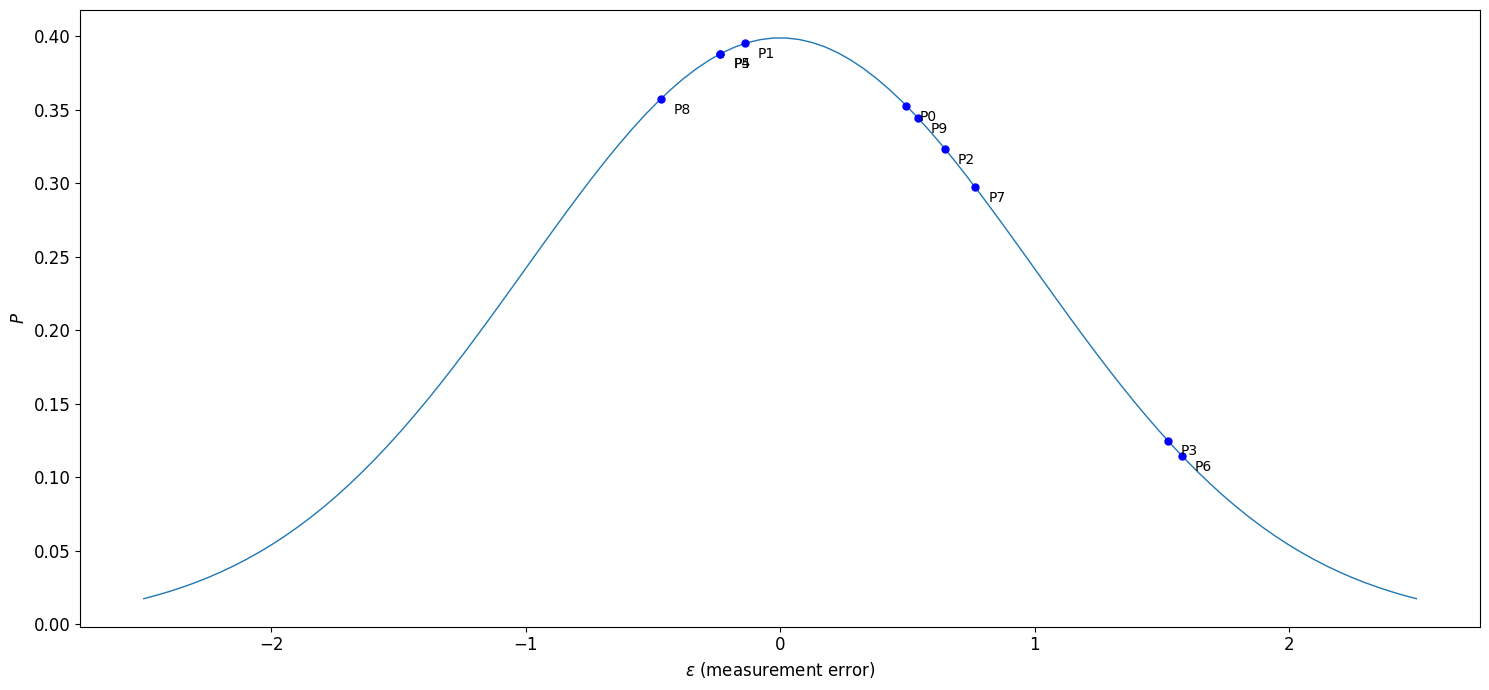

In [8]:
epsilons = np.linspace(-2.5*scale,2.5*scale,100)
p = stats.norm.pdf(epsilons, loc=0, scale=scale)

fig,ax=plt.subplots()
ax.plot(epsilons,p);

data['P'] = ϵ.pdf(data['ϵ'])

data.plot(x='ϵ', y='P', ax=ax, style='bo')
for index,row in data.iterrows():
    ax.text(x=row['ϵ']+0.05, y=row['P']-0.01, s=f'P{index}')


ax.set_xlabel(r'$\epsilon$ (measurement error)');
ax.set_ylabel(r'$P$');
ax.get_legend().set_visible(False)

This can be implemented as a for-loop:

In [9]:
likelihood = 1
for P in data['P']:
    likelihood*=P
likelihood

3.5608408142966706e-06

This kind of itterative product very quickly gets out of hand, if there is thousands or millions of data points the calculation gets very complicated. So there is a mathematical "trick" to instead used the log(PDF) where the products instead becomes a summation, which is much easier to work with.

So this is very nice, we can calculate the likelihood (or rather log-likelihood) that the data origins from a certain distribution. But how do we know that this is the most likely? Perhas there is another distribution that is more likely than the one we tested above? This turns into an optimization problem, maximizing the likelihood which in the case of a normal distribution with zero mean boils down into determine the standard deviation $\sigma$ of the distribution with highest likelihood. An analytical solution to the optimization problem can be found by finding the point where all the partial derivatives are zero. But instead we will use *scipy.optimize.minimize* to find a numerical solution instead. (The maximization problem needs to be reformulated into a minimization problem of the negative log-likelihood).

In [13]:
# define likelihood function
def MLERegression(params, v, f_y):
    beta, sd = params[0], params[1]
    yhat = beta*v # predictions
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(f_y, loc=yhat, scale=sd) )
    # return negative LL
    return(negLL)

In [14]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,2])
results = minimize(MLERegression, guess, args=(data['v'].values,data['f_y_measure'].values,), method = "Nelder-Mead")

In [15]:
results

 final_simplex: (array([[3.12377245, 0.73248341],
       [3.12375436, 0.73239791],
       [3.12370978, 0.73251669]]), array([11.07615179, 11.07615186, 11.07615189]))
           fun: 11.076151787450467
       message: 'Optimization terminated successfully.'
          nfev: 86
           nit: 45
        status: 0
       success: True
             x: array([3.12377245, 0.73248341])

So this optimization estimated $\beta$